In [1]:
from glob import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import similaritymeasures
import itertools
from multiprocessing import Pool
from functools import partial

In [2]:
def progress(iteration, total, message=None):
    '''Simple progressbar
    '''
    if message is None:
        message = ''
    bars_string = int(float(iteration) / float(total) * 50.)
    print("\r|%-50s| %d%% (%s/%s) %s "% ('█'*bars_string+ "░" * \
                                     (50 - bars_string), float(iteration)/\
                                     float(total) * 100, iteration, total, \
                                     message), end='\r', flush=True)

    if iteration == total:
        print('\nCompleted!')
        
        
def sim(curves):
    abc  = similaritymeasures.area_between_two_curves(curves[0][0], curves[1][0])
    mae  = similaritymeasures.mae(curves[0][0], curves[1][0])
    mse  = similaritymeasures.mse(curves[0][0], curves[1][0])
    return abc, mae, mse



pools = Pool()

melt_curves = k562[['Melt_curve']].values.tolist()
pair = list(itertools.combinations(melt_curves, 2))

abc = []
for result in pools.map(sim, pair):
    print(result)
    abc.append(result)
#    progress(len(abc), len(pair))
pools.close()
pools.join()

abc = pd.DataFrame(abc)
abc.columns = ['area_between_two_curves','mae','mse']
abc['combinations'] = list(itertools.combinations(k562.Accession.tolist(), 2))

### Distributions of MSEs

<Figure size 216x216 with 0 Axes>

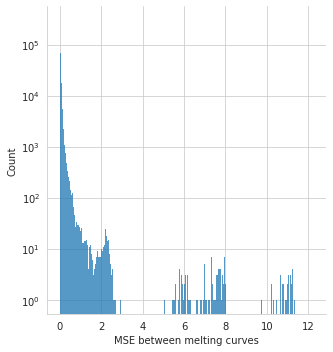

In [2]:
degreeC = [37, 40, 43, 46, 49, 52, 55, 58, 61, 64]
k562 = pd.read_excel('aan0346_Tables_S1_to_S18.xlsx', sheet_name='Table S7', skiprows=2)

k562['Melt_curve'] = k562[['T37', 'T40', 'T43', 'T46', 'T49','T52', 'T55', 'T58', 'T61', 'T64']].values.tolist()
k562['Melt_curve'] = k562['Melt_curve'].apply(lambda x: np.array([x, degreeC]).T)


abc = pd.read_pickle('abc.pkl.gz')
abc['Pairs'] = abc.combinations.apply(lambda x: '_'.join(sorted(x)))

sns.set_style('whitegrid')
plt.figure(figsize=(3,3))
sns.displot(abc.mse)
plt.yscale('log')
plt.xlabel('MSE between melting curves')
plt.savefig('all-vs-all_mse.png', bbox_inches='tight', dpi=300)

### Distributions of annotated PPIs and MSEs

In [3]:
dbs = pd.read_pickle('~/compartment/doc/heatmap/ppi_analysis/doc/jupyter/dbs.pkl.gz')

clus1 = abc[(abc.area_between_two_curves <= 50) & (abc.mse < 4)]
clus2 = abc[(abc.area_between_two_curves > 50) & (abc.mse >= 4) & (abc.mse < 8)]
clus3 = abc[(abc.area_between_two_curves > 50) & (abc.mse >= 8)]

clus_pairs = []

for i in dbs.DB.unique():
    clus_pairs.append([pd.merge(clus1, dbs[dbs.DB==i].drop_duplicates('Pairs'), on='Pairs').drop_duplicates('Pairs').shape[0], 
                       pd.merge(clus2, dbs[dbs.DB==i].drop_duplicates('Pairs'), on='Pairs').drop_duplicates('Pairs').shape[0], 
                       pd.merge(clus3, dbs[dbs.DB==i].drop_duplicates('Pairs'), on='Pairs').drop_duplicates('Pairs').shape[0]])
    
clus = pd.DataFrame(clus_pairs)
clus.columns = ['Distribution 1', 'Distribution 2', 'Distribution 3']
clus.insert(0, 'PPI databases', dbs.DB.unique())

clus

,PPI databases,Distribution 1,Distribution 2,Distribution 3
0,BioPlex 3.0,4336,0,0
1,BIOGRID 4.4.204,34314,0,1
2,DIP 20170205,2330,0,0
3,IntAct 2021-10-13,92651,0,3
4,mentha 2021-12-20,139284,0,3
5,MINT 2021-12-19,14731,0,0
6,signor 2022-01-03,4420,0,0
7,STRING 11.5,97596,2,4


In [4]:
clus.sum()

PPI databases     BioPlex 3.0BIOGRID 4.4.204DIP 20170205IntAct 2...
Distribution 1                                               389662
Distribution 2                                                    2
Distribution 3                                                   11
dtype: object

In [5]:
clus1.shape, clus2.shape, clus3.shape 

((34084890, 5), (15990, 5), (8759, 5))

In [6]:
abc_pos = pd.merge(dbs[['Pairs']].drop_duplicates('Pairs'), abc, on='Pairs').drop_duplicates('Pairs')
abc_neg = pd.concat([abc_pos,abc]).drop_duplicates('Pairs', keep=False)

abc_pos['Interact'] = 1
abc_neg['Interact'] = 0
anno = pd.concat([abc_pos,abc_neg])

### LazyPair STRING:full model

In [7]:
lp = pd.read_csv('lazypair_k562.out.gz', sep='\t')
lp['Pairs'] = lp[['Protein1','Protein2']].values.tolist()
lp['Pairs'] = lp.Pairs.apply(lambda x: '_'.join(sorted(x)))


full = pd.merge(lp, abc, on='Pairs').drop_duplicates('Pairs')
full_pos = full[full['STRING:full']>0.9].copy()
full_neg = full[full['STRING:full']<0.1].copy()

full_pos['Interact'] = 1
full_neg['Interact'] = 0
full = pd.concat([full_pos,full_neg])

### LazyPair STRING:binding model

In [8]:
bind = pd.merge(lp, abc, on='Pairs').drop_duplicates('Pairs')
bind_pos = bind[bind['STRING:binding']>0.9].copy()
bind_neg = bind[bind['STRING:binding']<0.1].copy()

bind_pos['Interact'] = 1
bind_neg['Interact'] = 0
bind = pd.concat([bind_pos,bind_neg])

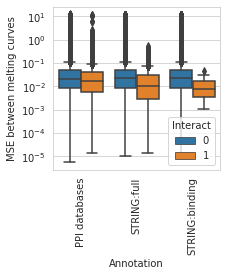

In [9]:
anno['Annotation'] = 'PPI databases'
full['Annotation'] = 'STRING:full'
bind['Annotation'] = 'STRING:binding'

preds = pd.concat([anno[['Annotation','Interact','mse']], full[['Annotation','Interact','mse']], bind[['Annotation','Interact','mse']]])

plt.figure(figsize=(3,3))
sns.boxplot(data=preds, hue='Interact', y=preds.mse, x='Annotation')
plt.yscale('log')
plt.ylabel('MSE between melting curves')
plt.xticks(rotation=90)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('annotation-vs-mse_k562.png', bbox_inches='tight', dpi=300)